## 机器学习工程师纳米学位毕业项目

作者 meelo

### 加载经过预处理的数据

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle

pickle_file = 'svhn_single.pickle'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    train_dataset = dataset['train_dataset']
    train_labels = dataset['train_labels']
    valid_dataset = dataset['valid_dataset']
    valid_labels = dataset['valid_labels']
    test_dataset = dataset['test_dataset']
    test_labels = dataset['test_labels']
    del dataset
    
print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)
print('Validing dataset shape: ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)
print('Testing dataset shape: ', test_dataset.shape)
print('Testing labels shape: ', test_labels.shape)

Training dataset shape:  (72525, 32, 32)
Training labels shape:  (72525,)
Validing dataset shape:  (732, 32, 32)
Validing labels shape:  (732,)
Testing dataset shape:  (26032, 32, 32)
Testing labels shape:  (26032,)


In [2]:
import resource
print("{} Kb".format(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))

2000564 Kb


### 将数据修改成适合TensorFlow的格式

- 卷积要求图片数据的形状为(宽度×高度×通道数)
- 图片的标签需要进行1-hot编码，并转换成浮点数


![](./images/onehot.png)

In [3]:
print(train_labels[100:110])

[ 9  9  5  3  2  4  5 10  2  1]


在原始数据中，数字1-9的标签是1-9，而数字0的标签是10。为了确保1-hot编码，表示是否为0的标签在第1列，应当使用语句`np.array([10,1,2,3,4,5,6,7,8,9]) == labels`。

将10替换成0
不然argmax不对应

In [4]:
IMAGE_SIZE = 32
NUM_LABELS = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, num_channels)).astype(np.float32)
    #labels = (np.array([10,1,2,3,4,5,6,7,8,9]) == labels).astype(np.float32) # one-hot encoding
    labels[labels==10] = 0
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (72525, 32, 32, 1) (72525,)
Validation set (732, 32, 32, 1) (732,)
Test set (26032, 32, 32, 1) (26032,)


In [5]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels)
          / predictions.shape[0])

truncated normal  
soft max  
cross entroy loss  
regularizers  
learning rate decay
训练时dropout  
sparse  
随机梯度下降 Momumtum  
部分加载数据

In [10]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH = 32
NUM_HIDDEN = 64
SEED = 42

import tensorflow as tf

# conv1 

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, num_channels))
    tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, num_channels, DEPTH], stddev=0.1))
    conv1_biases = tf.Variable(tf.zeros([DEPTH]))
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH, DEPTH], stddev=0.1))
    conv2_biases = tf.Variable(tf.zeros([DEPTH]))
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//4 * IMAGE_SIZE//4 * DEPTH, NUM_HIDDEN], stddev=0.1))
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    fc2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data, train=False):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        if train:
            hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
        return tf.matmul(hidden, fc2_weights) + fc2_biases
    
    logits = model(tf_train_dataset, True)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) + tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases)
    loss += 5e-4 * regularizers
    
    batch = tf.Variable(0, dtype=tf.float32)
    #decayed_learning_rate = learning_rate *
    #                    decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay(
        0.01, # Base learning rate
        batch * BATCH_SIZE, # Current index into the dataset
        train_labels.shape[0]/4, # Decay step
        0.95, # Decay rate,
        staircase=True
    )
    
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

定义参数

In [7]:
flags = tf.app.flags
FLAGS = flags.FLAGS

flags.DEFINE_boolean('training', True, 'If true do the training else load already trained model.')
flags.DEFINE_string('checkpoint_dir', 'model/', 'Checkpoint directory')

训练后期，loss及准确率波动较大，应当使用学习率exponential decay

### 最佳模型
Validation accuracy: 83.5%  
Test accuracy: 82.5%

训练集使用过一次之后，随机打乱

In [ ]:
import time
import datetime

num_steps = 2001

FLAGS.training = True

start_time = time.time()
with tf.Session(graph=graph) as session:
    if FLAGS.training:
        tf.initialize_all_variables().run()
        print('Initialized')
        for step in range(num_steps):
            offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
            batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
            batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, lr, predictions = session.run([optimizer, loss, learning_rate, train_prediction], feed_dict=feed_dict)
            if (step % 50 == 0):
                elapsed_time = time.time() - start_time
                start_time = time.time()
                print('Minibatch loss at step %d: %f, learning rate: %.6f, %.1f ms' % (step, l, lr, elapsed_time))
                print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
                print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels))
        saver.save(session, FLAGS.checkpoint_dir+'single.ckpt', write_meta_graph=False)
    else:
        saver.restore(session, FLAGS.checkpoint_dir+'single.ckpt')
    predictions = test_prediction.eval()
    print('Test accuracy: %.1f%%' % accuracy(predictions, test_labels))

Initialized
Minibatch loss at step 0: 3.514992, learning rate: 0.010000, 0.6 ms
Minibatch accuracy: 12.5%
Validation accuracy: 9.8%
Minibatch loss at step 50: 2.485899, learning rate: 0.010000, 13.7 ms
Minibatch accuracy: 26.6%
Validation accuracy: 22.7%
Minibatch loss at step 100: 2.540582, learning rate: 0.010000, 13.5 ms
Minibatch accuracy: 14.1%
Validation accuracy: 22.3%
Minibatch loss at step 150: 2.397921, learning rate: 0.010000, 13.1 ms
Minibatch accuracy: 28.1%
Validation accuracy: 22.3%
Minibatch loss at step 200: 2.490839, learning rate: 0.010000, 15.6 ms
Minibatch accuracy: 14.1%
Validation accuracy: 25.4%
Minibatch loss at step 250: 2.441463, learning rate: 0.010000, 14.8 ms
Minibatch accuracy: 25.0%
Validation accuracy: 22.4%
Minibatch loss at step 300: 2.399788, learning rate: 0.009500, 13.3 ms
Minibatch accuracy: 23.4%
Validation accuracy: 27.9%
Minibatch loss at step 350: 2.421201, learning rate: 0.009500, 13.3 ms
Minibatch accuracy: 20.3%
Validation accuracy: 26.9%
M

### 混淆矩阵

In [8]:
def confusionMatrix(labels, predictions):
    confusions = np.zeros([10, 10], np.float32)
    for actual, predicted in zip(labels, predictions):
        confusions[actual][predicted] += 1
    return confusions

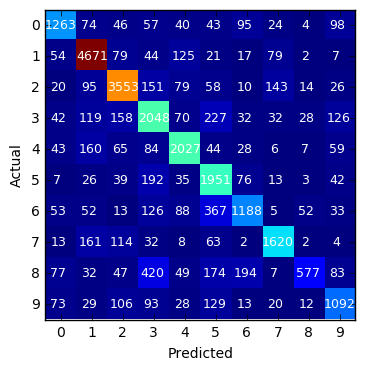

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
confusions = confusionMatrix(test_labels.astype(int), np.argmax(predictions, 1))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest')

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .085 * len(str(count))
            plt.text(j-xoff, i+.1, int(count), fontsize=9, color='white')